In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

def get_rotation(vector, alpha, beta, gamma): #pitch roll yaw
    pitch_matrix = np.array([[1,             0,              0],
                            [0, np.cos(alpha), -np.sin(alpha)],
                            [0, np.sin(alpha), np.cos(alpha)]])
    
    roll_matrix = np.array([[np.cos(-beta), -np.sin(-beta), 0],
                           [np.sin(-beta), np.cos(-beta), 0],
                           [0,             0,              1]])

    yaw_matrix = np.array([[np.cos(-gamma), 0,  np.sin(-gamma)],
                             [0,             1,            0],
                             [-np.sin(-gamma), 0, np.cos(-gamma)]])
    rotation_matrix = yaw_matrix@pitch_matrix@roll_matrix
    return rotation_matrix@vector

def get_translation(vector, tx, ty, tz):
    translation_matrix = np.array([[1, 0, 0, tx],
                                   [0, 1, 0, -ty],
                                   [0, 0, 1, -tz],
                                   [0, 0, 0,  1]])
    vector = translation_matrix@np.append(vector, [1], axis=0)
    return vector[:3]

def get_transform(vector, tx, ty, tz, rx, ry, rz): 
    vector = get_translation(vector, tx, ty, tz)
    vector = get_rotation(vector, rx, ry, rz)
    return vector

def normalize(vector):
    return vector / np.linalg.norm(vector)

class Scene():
    def __init__(self,
                 width,
                 height,
                 objects,
                 light = True):
        self.w = np.array(width)
        self.h = np.array(height)
        self.ratio = width / height
        self.objects = objects
        self.image = np.zeros((height, width, 3))
        self.ka = 0.05
        self.alpha = 30
        self.light = light

    def add_light(self,
                  light_position,
                  light_color=(1, 1, 1)):
        self.Lo = np.array(light_position)
        self.Lc = np.array(light_color)

    def get_normal(self, intersection, object):
        return normalize(intersection - object.position)

    def add_camera(self,
                   camera_position,
                   camera_direction,
                   camera_tilt=None,
                   depth_limit=3):
        if camera_tilt is None:
            camera_tilt = [0, 0, 1]
        self.Co = np.array(camera_position)
        self.Cd = normalize(np.array(camera_direction) - self.Co)
        self.Cu = normalize(np.array(camera_tilt))
        self.Cr = normalize(np.cross(self.Cd, self.Cu))
        self.hFOV = 15
        self.depth = depth_limit
        self.pixel_w = 2 * np.tan(np.radians(self.hFOV / 2)) / self.w
        self.pixel_h = self.pixel_w

    def intersection(self, ray_origin, ray_direction, object):
        if object.type == 'sphere':
            # Ray-Sphere intersection
            O = ray_origin
            D = ray_direction
            P0 = object.position
            R = object.radius

            a = np.dot(D, D)  # always 1
            b = 2 * np.dot(D, O - P0)
            c = np.dot(O - P0, O - P0) - R * R
            discriminant = b * b - 4 * a * c
            if discriminant > 0:  # two roots
                t1 = (-b + np.sqrt(discriminant)) / (2.0 * a)
                t2 = (-b - np.sqrt(discriminant)) / (2.0 * a)

                if t1 > 0 and t2 > 0:  # find closest intersection
                    distance = np.min([t1, t2])
                elif t1 <= 0 and t2 <= 0:  # no intersection
                    distance = np.inf
                else:
                    distance = np.max([t1, t2])

            elif discriminant == 0:  # one root
                t = -b / (2 * a)
                distance = t

            elif discriminant < 0:  # no root
                distance = np.inf

            intersection = O + distance * ray_direction
            return distance, intersection

    def trace(self, ray_origin, ray_direction):
        # Step 1: Find the closest object
        min_distance = np.inf
        closest_object = None
        closest_object_idx = None
        closest_intersection = None  # closest intersection point
        for o, obj in enumerate(self.objects):
            distance, intersection = self.intersection(ray_origin, ray_direction, obj)
            if distance < min_distance:
                min_distance = distance
                closest_object = obj
                closest_object_idx = o
                closest_intersection = intersection
        if min_distance == np.inf:  # no object
            return np.array([0.2, 0.2, 0.2])

        # Step 2: Get properties of the closest object
        if self.light:
            ambient_color = closest_object.color
            diffuse_color = closest_object.color
            specular_color = self.Lc
            N = self.get_normal(closest_intersection, closest_object)
            L = normalize(self.Lo - closest_intersection)
            V = normalize(ray_origin - closest_intersection)
            H = normalize(L + V)
    
            # Step 3: Find if the intersection point is shadowed or not.
            distance_to_other_objects = []
            for o, obj in enumerate(self.objects):
                if o != closest_object_idx:
                    distance, _ = self.intersection(closest_intersection + N * .0001,
                                                    L,
                                                    obj)
                    distance_to_other_objects.append(distance)
    
            # Step 4: Apply Blinn-Phong reflection model
            color = self.ka * ambient_color  # add ambient
            if np.min(distance_to_other_objects) < np.inf:  # intersection point is shadowed
                return color
            color += closest_object.kd * max(np.dot(N, L), 0) * diffuse_color  # add diffuse
            color += closest_object.ks * max(np.dot(N, H), 0) ** self.alpha * specular_color  # add specular
            return color
        else:
            # Step 2: Get properties of the closest object
            color = closest_object.color
            # Step 3:
            return color
                
    def render(self):
        for x in range(self.w):
            for y in range(self.h):
                dx = self.pixel_w * (x - self.w / 2)
                dy = - self.pixel_h * (y - self.h / 2)

                O = self.Co  # Origin of ray
                D = normalize(self.Cd + dx * self.Cr + dy * self.Cu)  # Direction of ray

                color = self.trace(O, D)
                self.image[y, x] = np.clip(color, 0, 1)

    def draw(self, dpi=100):
        plt.figure(dpi=dpi, figsize=(3.2, 2.4))
        plt.imshow(self.image)
        plt.xticks([])
        plt.yticks([])
        plt.show()

    def save(self, filename):
        image = np.flip(self.image, axis=1)
        image = 255.0 * image
        image = image.astype(np.uint8)
        im = Image.fromarray(image).resize((320, 240), Image.NEAREST)
        im.save(filename)

class Sphere():
    def __init__(self, position, radius, color, diffuse_k, specular_k):
        self.type = 'sphere'
        self.position = position
        self.radius = radius
        self.color = np.array(color)
        self.kd = diffuse_k
        self.ks = specular_k

class Head():
    def __init__(self):
        self.position = np.array([0,0,0])
        self.kd = 1.0
        self.ks = 1.0
        self.headball_radius = 0.0947
        self.headball_color = (1,1,1) #(0,1,0)

        self.headball = Sphere(position=self.position,
                               radius=self.headball_radius,
                               color=self.headball_color,
                               diffuse_k=self.kd,
                               specular_k=self.ks)
        self.objects = [self.headball]

        self.eyeball_radius = 0.01185
        self.eyeball_color = (1,1,1)
        self.pupil_distance = 0.01
        self.pupil_radius = 0.0025
        self.pupil_color = (0,0,0)
        self.set_gaze()

        self.have_eyeball_left = False
        self.have_eyeball_right = False
    def add_eyeball_left(self, eyeball_position = np.array([-0.0315, 0.0847, 0.0037])):
        self.position_left = eyeball_position
        self.have_eyeball_left = True
        eyeball = Sphere(position=eyeball_position,
                                   radius=self.eyeball_radius,
                                   color=self.eyeball_color,
                                   diffuse_k=self.kd,
                                   specular_k=self.ks)

        # calculate gaze direction of left eyeball
        gaze_direction = normalize(self.gaze_target - eyeball_position)

        pupil_position = eyeball_position + gaze_direction*self.pupil_distance
        pupil =  Sphere(position=pupil_position, radius=self.pupil_radius,
                        color=self.pupil_color, diffuse_k=self.kd, specular_k=self.ks)
        self.objects.append(eyeball)
        self.objects.append(pupil)

    def add_eyeball_right(self, eyeball_position = np.array([+0.0315, 0.0847, 0.0037])):
        self.position_right = eyeball_position
        self.have_eyeball_right = True
        eyeball = Sphere(position=eyeball_position,
                           radius=self.eyeball_radius,
                           color=self.eyeball_color,
                           diffuse_k=self.kd,
                           specular_k=self.ks)

        # calculate gaze direction of left eyeball
        gaze_direction = normalize(self.gaze_target - eyeball_position)
        pupil_position = eyeball_position + gaze_direction*self.pupil_distance
        pupil =  Sphere(position=pupil_position, radius=self.pupil_radius,
                        color=self.pupil_color, diffuse_k=self.kd, specular_k=self.ks)
        self.objects.append(eyeball)
        self.objects.append(pupil)

    def motion(self, tx, ty, tz, rx, ry, rz):
        self.position = get_transform(self.position, tx, ty, tz, rx, ry, rz)
        self.headball = Sphere(position=self.position,
                               radius=self.headball_radius,
                               color=self.headball_color,
                               diffuse_k=self.kd,
                               specular_k=self.ks)
        self.objects = [self.headball]
        if self.have_eyeball_left:
            eyeball_position = get_transform(self.position_left, tx, ty, tz, rx, ry, rz)
            self.position_left = eyeball_position
            eyeball = Sphere(position=eyeball_position,
                           radius=self.eyeball_radius,
                           color=self.eyeball_color,
                           diffuse_k=self.kd,
                           specular_k=self.ks)

            # calculate gaze direction of left eyeball
            gaze_direction = normalize(self.gaze_target - eyeball_position)
            pupil_position = eyeball_position + gaze_direction*self.pupil_distance
            pupil =  Sphere(position=pupil_position, radius=self.pupil_radius,
                            color=self.pupil_color, diffuse_k=self.kd, specular_k=self.ks)
            self.objects.append(eyeball)
            self.objects.append(pupil)

        if self.have_eyeball_right:
            eyeball_position = get_transform(self.position_right, tx, ty, tz, rx, ry, rz)
            self.position_right = eyeball_position
            eyeball = Sphere(position=eyeball_position,
                           radius=self.eyeball_radius,
                           color=self.eyeball_color,
                           diffuse_k=self.kd,
                           specular_k=self.ks)

            # calculate gaze direction of left eyeball
            gaze_direction = normalize(self.gaze_target - eyeball_position)
            pupil_position = eyeball_position + gaze_direction*self.pupil_distance
            pupil =  Sphere(position=pupil_position, radius=self.pupil_radius,
                            color=self.pupil_color, diffuse_k=self.kd, specular_k=self.ks)
            self.objects.append(eyeball)
            self.objects.append(pupil)

    def set_gaze(self, gaze=np.array([0.0, 1.0, 0.0])):
        self.gaze_target = gaze

    def reset(self):
        self.objects = [self.headball]

class Screen():
    def __init__(self):
        # screen width in pixel
        self.screen_width_px = 1600
        self.screen_height_px = 1000

        # screen width in meter
        self.screen_width_m = 0.36
        self.screen_height_m = 0.23

        self.screen_distance = 1.0+0.0847+0.01

        self.screen_width_space = np.linspace(-self.screen_width_m/2, +self.screen_width_m/2, self.screen_width_px+1)
        self.screen_height_space = np.linspace(+self.screen_height_m/2, -self.screen_height_m/2, self.screen_height_px+1)
    def get_target(self, pixels):
        px_x = pixels[0]
        px_y = pixels[1]
        return np.array([self.screen_width_space[px_x], self.screen_distance, self.screen_height_space[px_y]])



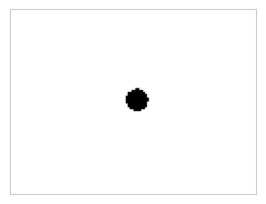

In [2]:
screen = Screen()
gaze_target = screen.get_target(np.array([800,500]))

head = Head()
head.set_gaze(gaze=gaze_target)
head.add_eyeball_left()

scene = Scene(width=128, height=96, objects=head.objects, light=False)
deg = 0
rad = np.deg2rad(deg)
scene.add_camera(camera_position=(-0.035,0.25,0.0037), camera_direction=(0,-1,0), camera_tilt=[np.sin(rad),0,np.cos(rad)])
scene.add_light(light_position=(0, 1.0, 1.0), light_color=(1, 1, 1))
scene.render()
scene.draw()

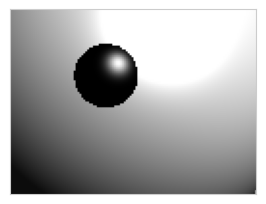

In [3]:
screen = Screen()
gaze_target = screen.get_target(np.array([800,500]))

head = Head()
head.set_gaze(gaze=gaze_target)
head.add_eyeball_left()

scene = Scene(width=128, height=96,objects=head.objects, light=True)
deg = +40
rad = np.deg2rad(deg)
scene.add_camera(camera_position=(-0.035,0.15,0.0037), camera_direction=(0,-1,0), 
                 camera_tilt = [np.sin(rad),0,np.cos(rad)])
scene.add_light(light_position=(0, 1.0, 1.0), light_color=(1, 1, 1))
scene.render()
scene.draw()

In [4]:
x_direction_range = np.linspace(-np.deg2rad(5), np.deg2rad(5), 9)
z_direction_range = np.linspace(-np.deg2rad(5), np.deg2rad(5), 9)
orientation_range = np.arange(-90, 91, 5)
depth_range = [0,15, 0.16, 0.17, 0.18, 0.19, 0.20, 0.21, 0.22, 0.23, 0.24, 0.25]
total_count = len(x_direction_range)*len(z_direction_range)*len(depth_range)*len(orientation_range)*12
print(total_count, total_count/12)

parameters = []
index = 0
for x, x_d in enumerate(x_direction_range):
    for z, z_d in enumerate(z_direction_range):
        for depth in depth_range:
            for d, deg in enumerate(orientation_range):
                rad = np.deg2rad(deg)
                parameters.append((index, x_d, z_d, depth, rad))
                index += 1

431568 35964.0


In [5]:
def get_basis(parameter):
    calibration_points = np.array([[200, 166], [200, 500], [200, 833],
                               [600, 166], [600, 500], [600, 833],
                               [1000, 166], [1000, 500], [1000, 833],
                               [1400, 166], [1400, 500], [1400, 833]])
    calibration_order = [4,11,6,2,7,0,10,5,9,8,1,3]
    
    index, x_d, z_d, depth, rad = parameter
    for t in range(12):
        target = calibration_points[calibration_order[t]]
        gaze_target = screen.get_target(target)
        head.set_gaze(gaze=gaze_target)
        head.add_eyeball_left()

        scene = Scene(width=128, height=96, objects=head.objects, light=False)
        scene.add_camera(camera_position=(-0.035,depth,0.0037), 
                         camera_direction=(x_d,-1,z_d), 
                         camera_tilt=[np.sin(rad),0,np.cos(rad)])
        #scene.add_light(light_position=(0, 1.0, 1.0), light_color=(1, 1, 1))
        scene.render()
        fig_number = int(12*index + t)
        scene.save(filename=f'basis/fig_{fig_number:09d}.png')
        head.reset()

from multiprocessing import Pool
with Pool() as pool:
    pool.map(get_basis, [parameter for parameter in parameters])


In [189]:
import pandas as pd

fixation_log_fname = f'camera_basis_log2.csv'
fixation_log_data = pd.read_csv(fixation_log_fname)
fixation_log_data = fixation_log_data[["center_x","center_y","confidence"]]
fixation_log_data_array = fixation_log_data.to_numpy()

camera_basis = []
camera_basis_info = []
idx = 0
for x, x_d in enumerate(x_direction_range):
    for z, z_d in enumerate(z_direction_range):
        for depth in depth_range:
            for d, deg in enumerate(orientation_range):
                tmp_basis = np.zeros((12,2))
                for t in range(12):
                    tmp_basis[t,:] = fixation_log_data_array[idx, :2]
                    idx += 1
                if np.any(tmp_basis == -1):
                    pass
                else:
                    camera_basis.append(tmp_basis)
                    camera_basis_info.append([x_d, z_d, depth, deg])
print(idx, fixation_log_data_array.shape, len(camera_basis))

camera_basis = np.array(camera_basis)
np.save("camera_basis.npy", camera_basis)

camera_basis_info = np.array(camera_basis_info)
np.save("camera_basis_info.npy", camera_basis_info)

101088 (101088, 3) 8253
